# Binance Trading bot

Notes:
1. Some terminology. *Base*: means the crypto we are trading. *Quote*: Is the stablecoin we use (i.e., crypto pegged to US$).
1. Add a *credentials.json* with your api keys in the same folder as the notebook.
1. So far the script has only executed sell orders, because I kill it everyday when I go to work it never bought crypto.
1. Api Documentation: https://python-binance.readthedocs.io/en/latest/index.html

In [1]:
%matplotlib notebook

import json
import time
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

from binance.client import Client
from binance.enums import *
from binance.helpers import round_step_size

## Connect to server

In [2]:
creds = json.load(open('credentials.json'))

client = Client(creds['api_key'], creds['api_secret'])
print('Problem connecting') if client.get_system_status()['status'] else print('Server is up')

Server is up


## Parameters

In [3]:
base = 'BTC' # crypto
quote = 'BUSD' # stablecoin
pair = base + quote # trading pair

interval = 10 # frequency of price check
reset = 200 # after how many checks reset the reference price
diff = 1.0007 # price difference threshold for order execution

## Functions

In [4]:
# Gets current price of base denominated in quote
def getPrice():
    return float(client.get_symbol_ticker(symbol = pair)['price'])

# Gets amount of base and quote assets that are free to trade (i.e., not held by an order)
def getAssets():
    assets = {}
    wallet = client.get_account()['balances']
    for a in wallet:
        if a['asset'] == base:
            assets[base] = float(a['free'])
        if a['asset'] == quote:
            assets[quote] = float(a['free'])
    return assets   

# Gets current balance in quote
def getBalance():
    baseVal = getPrice() * getAssets()[base]
    quoteVal = getAssets()[quote]
    return baseVal + quoteVal

# Buy when the price stops dropping
def buy(prevPrice):
    while getPrice() < prevPrice:
        prevPrice = getPrice()
        time.sleep(interval)
    refPrice = getPrice()
    print('Buy:', refPrice, ', Order:', makeOrder('BUY'))
        
# Sell whe the price stops growing
def sell(prevPrice):
    while getPrice() > prevPrice:
        prevPrice = getPrice()
        time.sleep(interval)
    refPrice = getPrice()
    print('Sell:', refPrice, ', Order:', makeOrder('SELL'))    

# Executes a market order
# Use create_test_order(.) to test. If all goes well it returns {}
def makeOrder(s):
    if s == 'BUY':
#         q = getAssets()[quote]
        return client.create_order(symbol = pair, side = s, type = 'MARKET', quoteOrderQty = 190)
    q = str(getAssets()[base]) 
    q = float(q[:-3])
    return client.create_order(symbol = pair, side = s, type = 'MARKET', quantity = q)
    
def plot():
    plt.plot(balance)
    plt.title('Balance')
    fig.canvas.draw()     
    
def stats():
    s = '-' * 80 + '\n'
    s += 'Profit (%): ' + str(round(balance[-1] / balance[0], 2))
    s += ' | Profit: ' + str(round(balance[-1] - balance[0], 2))
    s += ' | Reset in: ' + str(reset - counter)
    s += ' | Current price: ' + str(currentPrice)
    s += ' | Reference price: ' + str(refPrice)
    s += ' | Next order: ' + order
    return s

## Trading loop

<IPython.core.display.Javascript object>


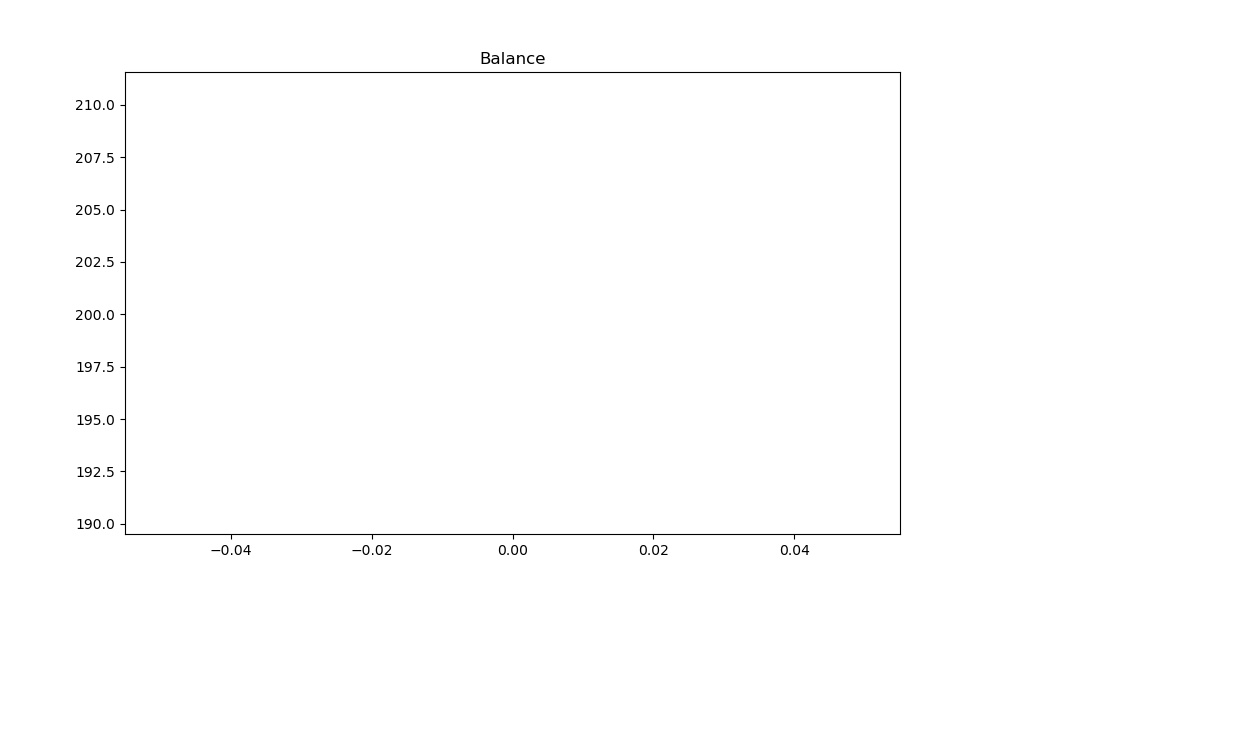

--------------------------------------------------------------------------------


In [ ]:
balance = []
order = 'BUY' # order to execute

refPrice = getPrice()
counter = 0

fig = plt.figure(figsize=(10, 6))
while True:
    
    counter += 1
    if counter == reset:
        counter = 0
        refPrice = getPrice()
        
    currentPrice = getPrice()
    
    # buy crypto
    if currentPrice <= refPrice / diff and order == 'BUY':
        buy(currentPrice)
        counter = 0
        order = 'SELL'
        
    # sell crypto
    elif currentPrice >= refPrice * diff and order == 'SELL':
        sell(currentPrice)
        counter = 0
        order = 'BUY'

    balance.append(getBalance())

    print(stats(), end='\r')
    plot()
    time.sleep(interval)